# Classify Neural Manifold Topology

### Set-up + Imports

In [2]:
import setup

setup.main()
%load_ext autoreload
%autoreload 2
%load_ext jupyter_black

import os

import matplotlib.pyplot as plt
import numpy as np
import torch

os.environ["GEOMSTATS_BACKEND"] = "pytorch"
import geomstats.backend as gs
import neurometry.datasets.synthetic as synthetic

Working directory:  /home/facosta/neurometry/neurometry
Directory added to path:  /home/facosta/neurometry
Directory added to path:  /home/facosta/neurometry/neurometry
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black


In [59]:
import neurometry.datasets.synthetic as synthetic

circle_task_points = synthetic.hypersphere(1, 1000)
circle_noisy_points, circle_manifold_points = synthetic.synthetic_neural_manifold(
    points=circle_task_points,
    encoding_dim=10,
    nonlinearity="sigmoid",
    scales=gs.ones(10),
    poisson_multiplier=100,
)

noise level: 0.71%


In [60]:
# Plot noisy_points and manifold_points in 3D with plotly

import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(
    go.Scatter3d(
        x=circle_noisy_points[:, 0],
        y=circle_noisy_points[:, 1],
        z=circle_noisy_points[:, 2],
        mode="markers",
        marker=dict(size=3),
    )
)

fig.add_trace(
    go.Scatter3d(
        x=circle_manifold_points[:, 0],
        y=circle_manifold_points[:, 1],
        z=circle_manifold_points[:, 2],
        mode="markers",
        marker=dict(size=3),
    )
)

fig.show()

In [61]:
from neurometry.estimators.topology.persistent_homology import compute_diagrams_shuffle


import neurometry.datasets.synthetic as synthetic

circle_task_points = synthetic.hypersphere(1, 1000)
circle_noisy_points, circle_manifold_points = synthetic.synthetic_neural_manifold(
    points=circle_task_points,
    encoding_dim=10,
    nonlinearity="sigmoid",
    scales=gs.ones(10),
    poisson_multiplier=100,
)

num_shuffles = 100

circle_noisy_diagrams = compute_diagrams_shuffle(
    circle_noisy_points, num_shuffles=num_shuffles, homology_dimensions=[0, 1, 2]
)


from gtda.diagrams import PersistenceEntropy

circle_PE = PersistenceEntropy()

circle_features = circle_PE.fit_transform(circle_noisy_diagrams)

# manifold_diagrams = compute_diagrams_shuffle(manifold_points, num_shuffles=num_shuffles)

In [20]:
X = noisy_points


def _shuffle_entries(data, rng):
    return np.array([rng.permutation(row) for row in data])


seed = 0
rng = np.random.default_rng(seed)
shuffled_Xs = [_shuffle_entries(X, rng) for _ in range(num_shuffles)]

In [21]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(
    go.Scatter3d(
        x=X[:, 0],
        y=X[:, 1],
        z=X[:, 2],
        mode="markers",
        marker=dict(size=3),
    )
)

i = 5

fig.add_trace(
    go.Scatter3d(
        x=shuffled_Xs[i][:, 0],
        y=shuffled_Xs[i][:, 1],
        z=shuffled_Xs[i][:, 2],
        mode="markers",
        marker=dict(size=3),
    )
)

In [33]:
from gtda.plotting import plot_diagram

plot_diagram(noisy_diagrams[0])

In [34]:
plot_diagram(noisy_diagrams[70])

In [62]:
from gtda.diagrams import PersistenceEntropy

circle_PE = PersistenceEntropy()

circle_features = circle_PE.fit_transform(circle_noisy_diagrams)

In [40]:
# 3d plot with plotly
fig = go.Figure()

fig.add_trace(
    go.Scatter3d(
        x=features[1:, 0],
        y=features[1:, 1],
        z=features[1:, 2],
        mode="markers",
        marker=dict(size=3, color="blue"),
    )
)

fig.add_trace(
    go.Scatter3d(
        x=[features[0, 0]],
        y=[features[0, 1]],
        z=[features[0, 2]],
        mode="markers",
        marker=dict(size=3, color="red"),
    )
)

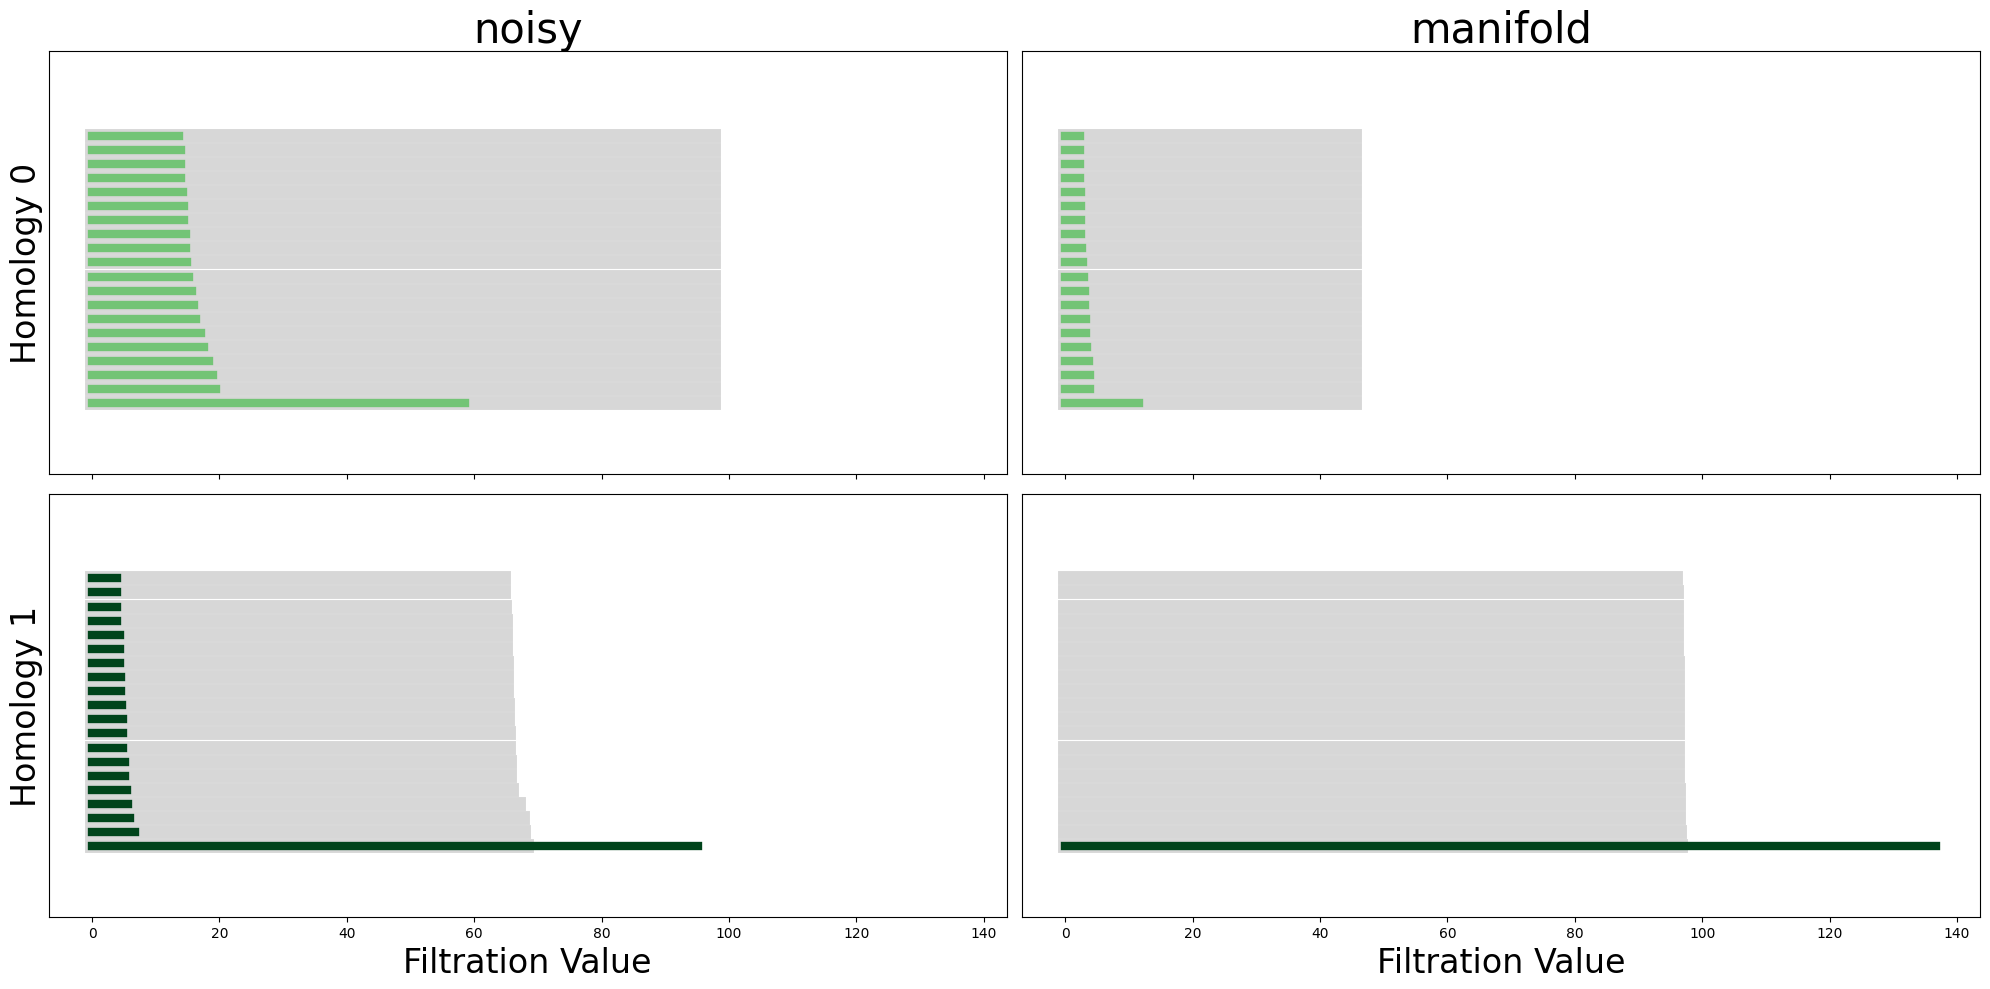

In [9]:
from neurometry.estimators.topology.plotting import plot_all_barcodes_with_null

plot_all_barcodes_with_null(
    noisy_diagrams, "noisy", diagrams_2=manifold_diagrams, dataset_name_2="manifold"
);

In [10]:
def _get_lifespan_from_diagram(diagram):
    birth = diagram[:, 0]
    death = diagram[:, 1]
    if np.isfinite(death).any():
        inf_value = 3 * np.max(death[death != np.inf])
    else:
        inf_value = 1000
    death[death == np.inf] = inf_value
    lifespan = death - birth
    indices = np.argsort(-lifespan)[:20]

    return lifespan[indices]

In [11]:
def estimate_betti_numbers(points, num_shuffles, homology_dimensions=(0, 1, 2)):
    all_diagrams = compute_diagrams_shuffle(
        points, num_shuffles=num_shuffles, homology_dimensions=homology_dimensions
    )
    diagram = all_diagrams[0]
    shuffled_diagrams = all_diagrams[1:]

    betti_numbers = {dim: None for dim in homology_dimensions}

    for dim in homology_dimensions:
        filtered_diagram = diagram[diagram[:, 2] == dim]
        lifespan = _get_lifespan_from_diagram(filtered_diagram)
        filtered_shuffled_diagrams = np.array(
            [
                shuffled_diagrams[i, shuffled_diagrams[i, :, 2] == 1]
                for i in range(shuffled_diagrams.shape[0])
            ]
        )
        betti_number = []
        for diag in filtered_shuffled_diagrams:
            shuffled_lifespan = _get_lifespan_from_diagram(diag)
            significant_features = (lifespan > shuffled_lifespan).astype(int)
            betti_number.append(sum(significant_features))
        betti_numbers[dim] = (np.mean(betti_number), np.std(betti_number))

    return betti_numbers

In [13]:
betti_numbers = estimate_betti_numbers(
    manifold_points, num_shuffles=100, homology_dimensions=(0, 1, 2)
)
print(betti_numbers)

{0: (1.28, 2.209434316742636), 1: (1.0, 0.0), 2: (0.0, 0.0)}


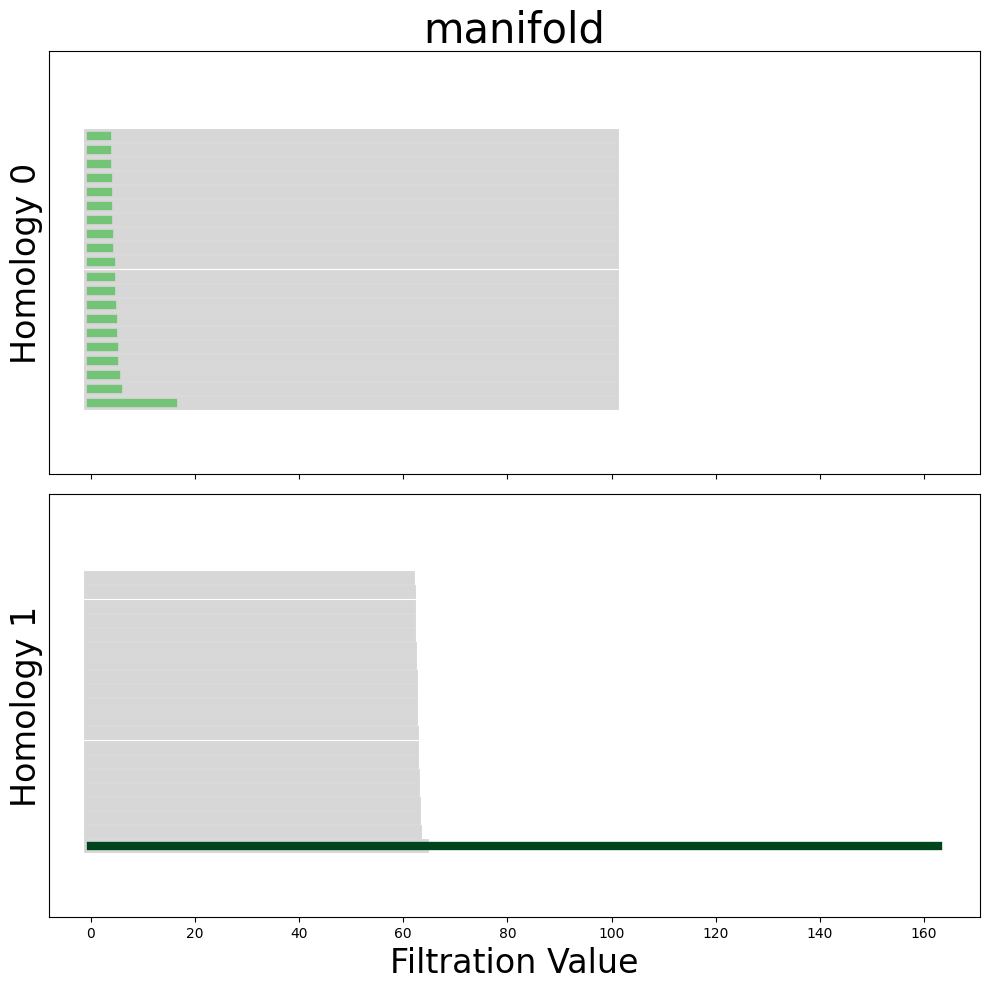

In [67]:
homology_dimensions = (0, 1)
points = manifold_points
num_shuffles = 100

all_diagrams = compute_diagrams_shuffle(
    points, num_shuffles=num_shuffles, homology_dimensions=homology_dimensions
)

plot_all_barcodes_with_null(all_diagrams, "manifold")


diagram = all_diagrams[0]
lifespan = _get_lifespan_from_diagram(diagram)
shuffled_diagrams = all_diagrams[1:]

betti_numbers = {dim: None for dim in homology_dimensions}

for dim in homology_dimensions:
    betti_number = []
    for shuffled_diagram in shuffled_diagrams:
        shuffled_lifespan = _get_lifespan_from_diagram(shuffled_diagram)
        significant_features = (lifespan > shuffled_lifespan).astype(int)
        betti_number.append(sum(significant_features))
    betti_numbers[dim] = np.mean(betti_number)

In [32]:
def get_betti_numbers(diagrams):
    original_diagram = diagrams[0]
    shuffled_diagrams = diagrams[1:]

    dims = np.unique(original_diagram[:, 2]).astype(int)

    betti_numbers = {dim: None for dim in dims}
    for i, dim in enumerate(dims):
        diagram_dim = original_diagram[original_diagram[:, 2] == dim]
        null_diagram_dim = shuffled_diagrams[:, :, 2] == dim
        null_diagram = shuffled_diagrams[null_diagram_dim]

        null_lifespans_dim = _get_lifespan_from_diagram(null_diagram)
        lifespans_dim = _get_lifespan_from_diagram(diagram_dim)

        comparison = (lifespans_dim > null_lifespans_dim).astype(int)

        betti_numbers[dim] = sum(comparison)

    return betti_numbers

In [33]:
betti = get_betti_numbers(noisy_diagrams)

In [34]:
betti

{0: 0, 1: 5, 2: 2}

### Classify circle, sphere, torus point clouds

In [68]:
import neurometry.datasets.synthetic as synthetic
from neurometry.estimators.topology.persistent_homology import compute_diagrams_shuffle
from gtda.diagrams import PersistenceEntropy

num_points = 1000
encoding_dim = 10
poisson_multiplier = 100
homology_dimensions = [0, 1, 2]
num_shuffles = 100

In [69]:
circle_task_points = synthetic.hypersphere(1, num_points)
circle_noisy_points, circle_manifold_points = synthetic.synthetic_neural_manifold(
    points=circle_task_points,
    encoding_dim=encoding_dim,
    nonlinearity="sigmoid",
    scales=gs.ones(encoding_dim),
    poisson_multiplier=poisson_multiplier,
)


circle_noisy_diagrams = compute_diagrams_shuffle(
    circle_noisy_points,
    num_shuffles=num_shuffles,
    homology_dimensions=homology_dimensions,
)

circle_PE = PersistenceEntropy()

circle_features = circle_PE.fit_transform(circle_noisy_diagrams)

noise level: 0.71%


In [70]:
sphere_task_points = synthetic.hypersphere(2, num_points)
sphere_noisy_points, sphere_manifold_points = synthetic.synthetic_neural_manifold(
    points=sphere_task_points,
    encoding_dim=encoding_dim,
    nonlinearity="sigmoid",
    scales=gs.ones(encoding_dim),
    poisson_multiplier=poisson_multiplier,
)

sphere_noisy_diagrams = compute_diagrams_shuffle(
    sphere_noisy_points,
    num_shuffles=num_shuffles,
    homology_dimensions=homology_dimensions,
)

sphere_PE = PersistenceEntropy()
sphere_features = sphere_PE.fit_transform(sphere_noisy_diagrams)

noise level: 0.71%


In [71]:
torus_task_points = synthetic.hypertorus(2, num_points)
torus_noisy_points, torus_manifold_points = synthetic.synthetic_neural_manifold(
    points=torus_task_points,
    encoding_dim=encoding_dim,
    nonlinearity="sigmoid",
    scales=gs.ones(encoding_dim),
    poisson_multiplier=poisson_multiplier,
)

torus_noisy_diagrams = compute_diagrams_shuffle(
    torus_noisy_points,
    num_shuffles=num_shuffles,
    homology_dimensions=homology_dimensions,
)

torus_PE = PersistenceEntropy()

torus_features = torus_PE.fit_transform(torus_noisy_diagrams)

noise level: 0.71%


In [72]:
# 3d plot with plotly
fig = go.Figure()

fig.add_trace(
    go.Scatter3d(
        x=circle_features[1:, 0],
        y=circle_features[1:, 1],
        z=circle_features[1:, 2],
        mode="markers",
        marker=dict(size=3, color="lightpink"),
        name="Shuffled Circle",
    )
)

fig.add_trace(
    go.Scatter3d(
        x=[circle_features[0, 0]],
        y=[circle_features[0, 1]],
        z=[circle_features[0, 2]],
        mode="markers",
        marker=dict(size=3, color="deeppink"),
        name="Circle",
    )
)

fig.add_trace(
    go.Scatter3d(
        x=sphere_features[1:, 0],
        y=sphere_features[1:, 1],
        z=sphere_features[1:, 2],
        mode="markers",
        marker=dict(size=3, color="lightgreen"),
        name="Shuffled Sphere",
    )
)

fig.add_trace(
    go.Scatter3d(
        x=[sphere_features[0, 0]],
        y=[sphere_features[0, 1]],
        z=[sphere_features[0, 2]],
        mode="markers",
        marker=dict(size=3, color="darkgreen"),
        name="Sphere",
    )
)

fig.add_trace(
    go.Scatter3d(
        x=torus_features[1:, 0],
        y=torus_features[1:, 1],
        z=torus_features[1:, 2],
        mode="markers",
        marker=dict(size=3, color="lightblue"),
        name="Shuffled Torus",
    )
)

fig.add_trace(
    go.Scatter3d(
        x=[torus_features[0, 0]],
        y=[torus_features[0, 1]],
        z=[torus_features[0, 2]],
        mode="markers",
        marker=dict(size=3, color="darkblue"),
        name="Torus",
    )
)

In [16]:
num_points = 500
encoding_dim = 10
poisson_multiplier = 100


test_task_points = synthetic.hypertorus(2, 400)
test_noisy_points, test_manifold_points = synthetic.synthetic_neural_manifold(
    points=test_task_points,
    encoding_dim=encoding_dim,
    nonlinearity="sigmoid",
    scales=gs.ones(encoding_dim),
    poisson_multiplier=poisson_multiplier,
)

from neurometry.estimators.topology.persistent_homology import TopologicalClassifier

num_samples = 10

TC = TopologicalClassifier(
    num_samples=num_samples, poisson_multiplier=poisson_multiplier, reduce_dim=True
)
TC.fit(test_noisy_points)

Classifier score: 1.0


TopologicalClassifier(num_samples=10, poisson_multiplier=100, reduce_dim=True)

In [17]:
TC.predict(test_noisy_points)

array([2.])

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin



class TopologicalClassifier(ClassifierMixin, BaseEstimator):
    def __init__(
        self,
        num_samples,
        poisson_multiplier,
        homology_dimensions=[0, 1, 2],
        reduce_dim=False,
    ):
        self.num_samples = num_samples
        self.poisson_multiplier = poisson_multiplier
        self.homology_dimensions = homology_dimensions
        self.reduce_dim = reduce_dim
        self.classifier = RandomForestClassifier()

    def _generate_ref_data(self, input_data):
        num_points = input_data.shape[0]
        encoding_dim = input_data.shape[1]
        circle_task_points = synthetic.hypersphere(1, num_points)
        circle_point_clouds = []
        for i in range(self.num_samples):
            circle_noisy_points, _ = synthetic.synthetic_neural_manifold(
                points=circle_task_points,
                encoding_dim=encoding_dim,
                nonlinearity="sigmoid",
                scales=gs.ones(encoding_dim),
                poisson_multiplier=self.poisson_multiplier,
            )
            circle_point_clouds.append(circle_noisy_points)

        sphere_task_points = synthetic.hypersphere(2, num_points)
        sphere_point_clouds = []
        for i in range(num_samples):
            sphere_noisy_points, _ = synthetic.synthetic_neural_manifold(
                points=sphere_task_points,
                encoding_dim=encoding_dim,
                nonlinearity="sigmoid",
                scales=gs.ones(encoding_dim),
                poisson_multiplier=self.poisson_multiplier,
            )
            sphere_point_clouds.append(sphere_noisy_points)

        torus_task_points = synthetic.hypertorus(2, num_points)
        torus_point_clouds = []
        for i in range(num_samples):
            torus_noisy_points, _ = synthetic.synthetic_neural_manifold(
                points=torus_task_points,
                encoding_dim=encoding_dim,
                nonlinearity="sigmoid",
                scales=gs.ones(encoding_dim),
                poisson_multiplier=self.poisson_multiplier,
            )
            torus_point_clouds.append(torus_noisy_points)

        klein_bottle_task_points = synthetic.klein_bottle(num_points)
        klein_bottle_point_clouds = []
        for i in range(num_samples):
            klein_bottle_noisy_points, _ = synthetic.synthetic_neural_manifold(
                points=klein_bottle_task_points,
                encoding_dim=encoding_dim,
                nonlinearity="sigmoid",
                scales=gs.ones(encoding_dim),
                poisson_multiplier=self.poisson_multiplier,
            )
            klein_bottle_point_clouds.append(klein_bottle_noisy_points)

        circle_labels = np.zeros(num_samples)
        sphere_labels = np.ones(num_samples)
        torus_labels = 2 * np.ones(num_samples)
        klein_bottle_labels = 3 * np.ones(num_samples)
        ref_labels = np.concatenate(
            [
                circle_labels,
                sphere_labels,
                torus_labels,
                klein_bottle_labels,
            ]
        )

        ref_point_clouds = [
            *circle_point_clouds,
            *sphere_point_clouds,
            *torus_point_clouds,
            *klein_bottle_point_clouds,
        ]

        return ref_point_clouds, ref_labels

    def _compute_topo_features(self, diagrams):
        PE = PersistenceEntropy()
        features = PE.fit_transform(diagrams)
        return features

    def fit(self, X, y=None):
        ref_point_clouds, ref_labels = self._generate_ref_data(X)
        if self.reduce_dim:
            pca = PCA(n_components=10)
            ref_point_clouds = [
                pca.fit_transform(point_cloud) for point_cloud in ref_point_clouds
            ]
        ref_diagrams = compute_persistence_diagrams(
            ref_point_clouds, homology_dimensions=self.homology_dimensions
        )
        ref_features = self._compute_topo_features(ref_diagrams)
        X_ref_train, X_ref_valid, y_ref_train, y_ref_valid = train_test_split(
            ref_features, ref_labels
        )
        self.classifier.fit(X_ref_train, y_ref_train)
        print(f"Classifier score: {self.classifier.score(X_ref_valid, y_ref_valid)}")
        return self

    def predict(self, X):
        if self.reduce_dim:
            pca = PCA(n_components=10)
            X = pca.fit_transform(X)
        diagram = compute_persistence_diagrams(
            [X], homology_dimensions=self.homology_dimensions
        )
        features = self._compute_topo_features(diagram)
        return self.classifier.predict(features)

In [8]:
test_task_points = synthetic.hypertorus(2, 400)
test_noisy_points, test_manifold_points = synthetic.synthetic_neural_manifold(
    points=test_task_points,
    encoding_dim=5,
    nonlinearity="sigmoid",
    scales=gs.ones(10),
    poisson_multiplier=100,
)

TC = TopologicalClassifier(num_samples=10, poisson_multiplier=100, reduce_dim=True)
TC.fit(test_noisy_points)

In [116]:
# Example color mapping
color_map = {0: "darkblue", 1: "deeppink", 2: "limegreen", 3: "orange"}
colors = [color_map[label] for label in labels]

names = {0: "Circle", 1: "Sphere", 2: "Torus", 3: "Klein Bottle"}

# Create a figure
fig = go.Figure()

# Add the trace with colored markers based on labels
fig.add_trace(
    go.Scatter3d(
        x=features[:, 0],
        y=features[:, 1],
        z=features[:, 2],
        mode="markers",
        marker=dict(size=3, color=colors),
        showlegend=False,
    )
)

# Manually add the legend entries
for label, color in color_map.items():
    fig.add_trace(
        go.Scatter3d(
            x=[None],
            y=[None],
            z=[None],
            mode="markers",
            marker=dict(size=3, color=color),
            showlegend=True,
            name=f"{names[label]}",
        )
    )

fig.show()

In [110]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(features, labels)
model = RandomForestClassifier()
model.fit(X_train, y_train)
model.score(X_valid, y_valid)

0.8

In [9]:
test_task_points = synthetic.hypertorus(2, 400)
test_noisy_points, test_manifold_points = synthetic.synthetic_neural_manifold(
    points=test_task_points,
    encoding_dim=5,
    nonlinearity="sigmoid",
    scales=gs.ones(10),
    poisson_multiplier=100,
)

TC.fit(test_noisy_points)

AssertionError: scales must have same shape as tensor

### NOTE: Try different coefficients to distinguish between torus and klein bottle?

In [105]:
betti_numbers = estimate_betti_numbers(
    manifold_points, num_shuffles=500, homology_dimensions=(0, 1)
)
print(betti_numbers)

{0: (19.814, 0.7066852198822331), 1: (13.214, 2.555817677378416)}


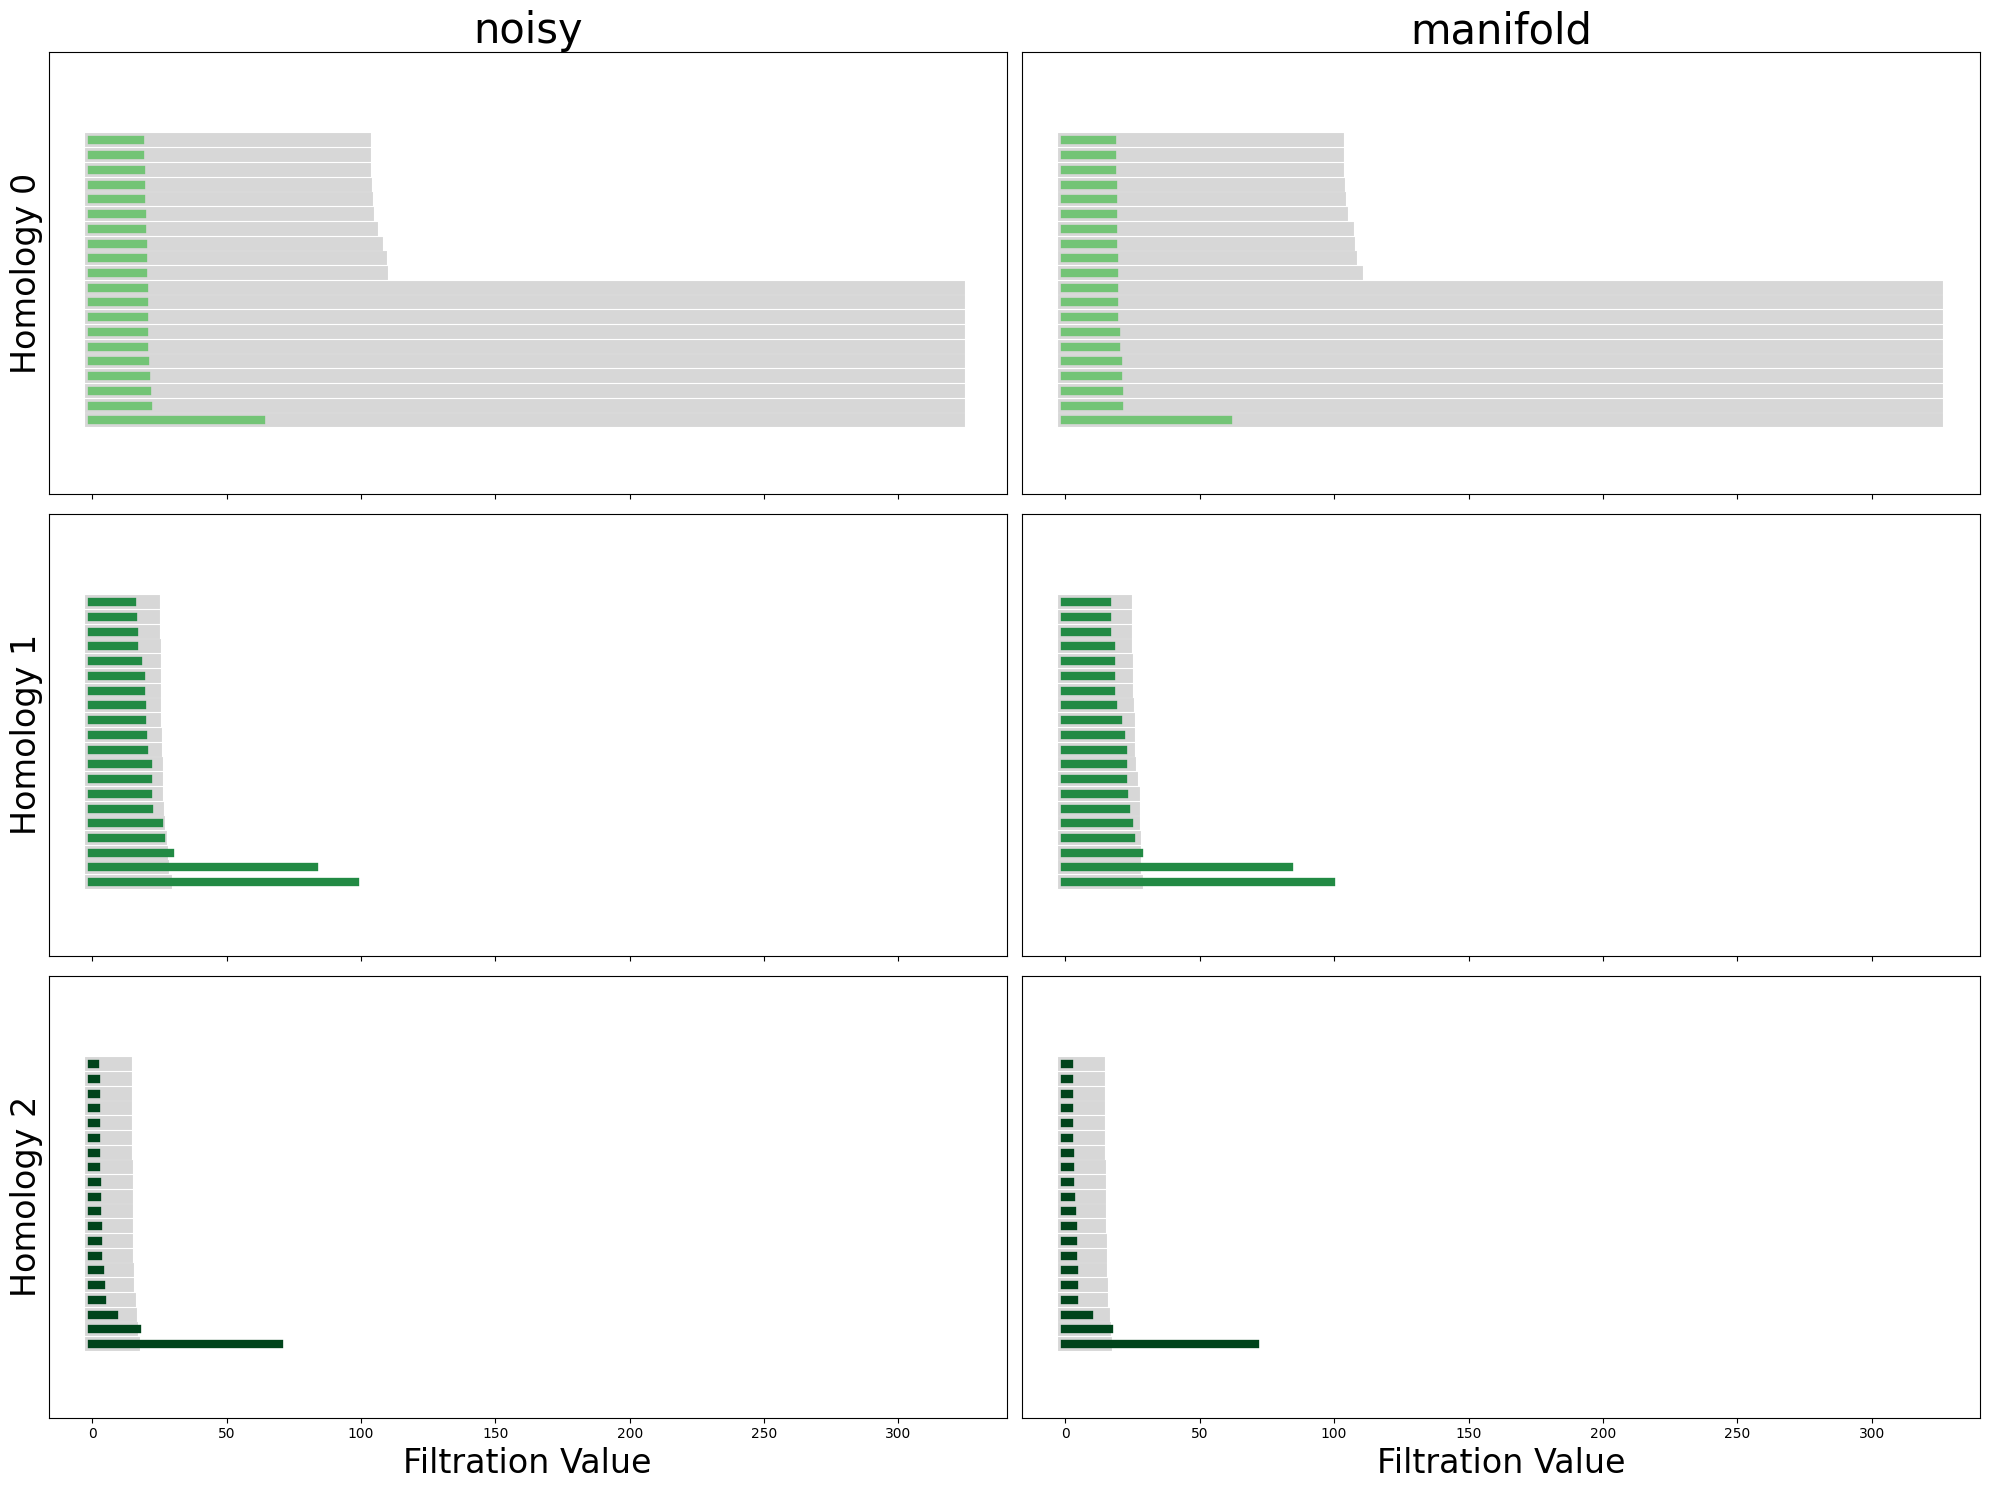

In [12]:
num_shuffles = 10

noisy_diagrams = compute_diagrams_shuffle(
    noisy_points, num_shuffles=num_shuffles, homology_dimensions=(0, 1, 2)
)

manifold_diagrams = compute_diagrams_shuffle(
    manifold_points, num_shuffles=num_shuffles, homology_dimensions=(0, 1, 2)
)

plot_all_barcodes_with_null(
    noisy_diagrams, "noisy", diagrams_2=manifold_diagrams, dataset_name_2="manifold"
);

In [13]:
betti = get_betti_numbers(noisy_diagrams)
print(betti)

{0: 0, 1: 5, 2: 2}


### TODO: FIX get_betti_numbers FUNCTION!!!!

Also: how to deal with betti 0 ? There should be a single "significant" feature?

In [14]:
sphere_1_betti = {0: 1, 1: 1, 2: 0}
torus_2_betti = {0: 1, 1: 2, 2: 1}
sphere_2_betti = {0: 1, 1: 0, 2: 1}

# if betti == sphere_1_betti:
#     print("The manifold is a ring") ----> use ring VAE


# elif betti == torus_2_betti: